# Configuration du notebook

In [254]:
# Data analysis libraries
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from wordcloud import WordCloud

# Image processing library
from PIL import Image

# Text processing libraries
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cramarokoto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [255]:
# Chargement des données
X_train = pd.read_csv("./../data/X_train_update.csv", index_col=0)
y_train = pd.read_csv("./../data/Y_train_CVw08PX.csv", index_col=0)
X_test = pd.read_csv("./../data/X_test_update.csv", index_col=0)

In [256]:
def data_info(df):
    df.info()
    print("\n")
    display(df.head())
    print("\n")


# Exploration des données

Les premières choses à comprendre concernant les données :

- X_train contient toutes les données que nous avons pour l'entraînement ET les tests : elles sont associées aux valeurs de y_train.
- X_test contient uniquement les données à classifier avec notre modèle afin d’être évalué dans le cadre du challenge Rakuten.
- Il en va de même pour les images.

## Description de X_train

In [257]:
data_info(X_train)

#### Nan values in X_train ####

print("NaN values in X_train")
X_train_nan = X_train.isna().sum()
print(X_train_nan)
print("\n")

print("Nan values ratio in X_train", X_train_nan / len(X_train))

#### Unique values in train variables ####

print("Unique value numbers in train variables :", end = "\n\n")
print(X_train.nunique(), end = "\n\n")

# Less unique values in Designation than productid and imageid -> Duplicates with different id ?

#### Duplicated values in train variables ####

print("# of duplicates in designation :", round(X_train.duplicated(subset = ["designation"]).sum()/len(X_train["designation"])*100, 2), "%")
print("# of duplicates in productid :", X_train.duplicated(subset = ["productid"]).sum())
print("# of duplicates in imageid :", X_train.duplicated(subset = ["imageid"]).sum())

# Duplicates of products with different productid and imageid

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   designation  84916 non-null  object
 1   description  55116 non-null  object
 2   productid    84916 non-null  int64 
 3   imageid      84916 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.2+ MB




designation  \
0  Olivia: Personalisiertes Notizbuch / 150 Seite...   
1  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...   
2  Grand Stylet Ergonomique Bleu Gamepad Nintendo...   
3  Peluche Donald - Europe - Disneyland 2000 (Mar...   
4                               La Guerre Des Tuques   

                                         description   productid     imageid  
0                                                NaN  3804725264  1263597046  
1                                                NaN   436067568  1008141237  
2  PILOT STYLE Touch Pen de marque Speedlink est ...   201115110   938777978  
3                                                NaN    50418756   457047496  
4  Luc a des id&eacute;es de grandeur. Il veut or...   278535884  1077757786



NaN values in X_train
designation        0
description    29800
productid          0
imageid            0
dtype: int64


Nan values ratio in X_train designation    0.000000
description    0.350935
productid      0.000000
imageid        0.000000
dtype: float64
Unique value numbers in train variables :

designation    82265
description    47506
productid      84916
imageid        84916
dtype: int64

# of duplicates in designation : 3.12 %
# of duplicates in productid : 0
# of duplicates in imageid : 0


Conformément à la description des données, seule la description est optionnelle, on remarque que le jeu de données est complet et que c'est la seule variable avec des valeurs nulles.

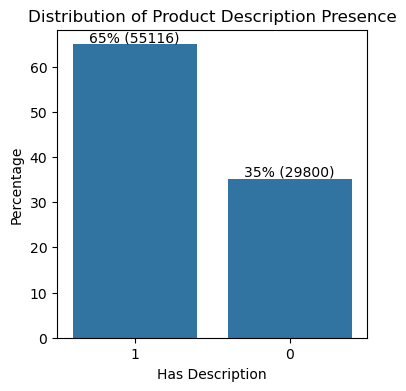

In [258]:
# Dichotomisation de la présence de description dans X_train
X_train['has_description'] = X_train['description'].notna().astype(int)

abs_values = X_train['has_description'].value_counts(ascending=False)
rel_values = X_train['has_description'].value_counts(ascending=False, normalize=True).values * 100
labels = [f'{p[1]:.0f}% ({p[0]})' for p in zip(abs_values, rel_values)]

# Affichage de la distribution de has_description
plt.figure(figsize=(4, 4))
ax = sns.countplot(data=X_train, x='has_description', order=X_train['has_description'].value_counts().index, stat='percent')
ax.bar_label(container=ax.containers[0], labels=labels)

plt.title('Distribution of Product Description Presence')
plt.xlabel('Has Description')
plt.ylabel('Percentage')
plt.show()

Il y a plus de produits avec une description (65 %) que de produits sans description (35%) malgré le caractère optionnel de la description. On peut supposer que cela est dû à l'importance de la description de l'article pour favoriser sa vente en plus de sa catégorisation. En effet, la description fournit d'autres éléments discriminant pour un produit dans le cadre de la recherche via un moteur parmi de nombreux produits.

## Description de y_train

In [259]:
data_info(y_train)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84916 entries, 0 to 84915
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   prdtypecode  84916 non-null  int64
dtypes: int64(1)
memory usage: 1.3 MB




prdtypecode
0           10
1         2280
2           50
3         1280
4         2705

In [260]:
# Nombre de valeurs uniques dans y_train
print("Unique values in y_train")
display(y_train.value_counts())

print("\n")
print("Count of unique values :", y_train.nunique())

Unique values in y_train


prdtypecode
2583           10209
1560            5073
1300            5045
2060            4993
2522            4989
1280            4870
2403            4774
2280            4760
1920            4303
1160            3953
1320            3241
10              3116
2705            2761
1140            2671
2582            2589
40              2508
2585            2496
1302            2491
1281            2070
50              1681
2462            1421
2905             872
60               832
2220             824
1301             807
1940             803
1180             764
dtype: int64



Count of unique values : prdtypecode    27
dtype: int64


Il existe 27 classes de produits distinctes dans le jeu de données d'apprentissage.
Malgré une recherche de la taxonomie exacte des produits rakuten, nous n'avons pas réussi à avoir accès aux labels exacts des classes de produits. Pour faciliter la compréhension des données, nous avons décidé de les nommer nous même suite à l'exploration des données pour chaque catégorie. Nous ajoutons donc cette variable à y_train.

In [261]:
labels = pd.read_csv("./../data/prdtypecode_labels.csv", index_col=0)
display(labels)

y_train = y_train.merge(labels, on="prdtypecode", how="left")
display(y_train)

prdtypecode_label
prdtypecode                                                   
10                                                      livres
40                                                  jeux video
50                                       accesoires jeux video
60                                      consoles de jeux video
1140                           produits derivés de jeux vidéos
1160                                    cartes collectionables
1180            figurines collectionnables pour jeu de société
1280                                 jouets, peluches, poupées
1281                                           jeux de société
1300                          voitures miniatures et maquettes
1301              accesoires et jeux pour petits enfants/bébés
1302                                          jeux d'exterieur
1320                                accessoires petite enfance
1560                      mobilier de rangement pour la maison
1920                                           linge de maison
1940                                                nourriture
2060                      accesoires de décoration pour maison
2220                     accessoires pour animaux de compagnie
2280                                                 magazines
2403                                             livres et bds
2462          consoles de jeux vidéo et jeux vidéos d'occasion
2522                 produits de papeterie et rangement bureau
2582                       mobilier d'extérieur et accessoires
2583                                    accessoires de piscine
2585         outillage et accessoires pour travaux ou jardi...
2705                                                    livres
2905                                    jeux en téléchargement

prdtypecode                          prdtypecode_label
0               10                                     livres
1             2280                                  magazines
2               50                      accesoires jeux video
3             1280                  jouets, peluches, poupées
4             2705                                     livres
...            ...                                        ...
84911           40                                 jeux video
84912         2583                     accessoires de piscine
84913         2280                                  magazines
84914         1560       mobilier de rangement pour la maison
84915         2522  produits de papeterie et rangement bureau

[84916 rows x 2 columns]

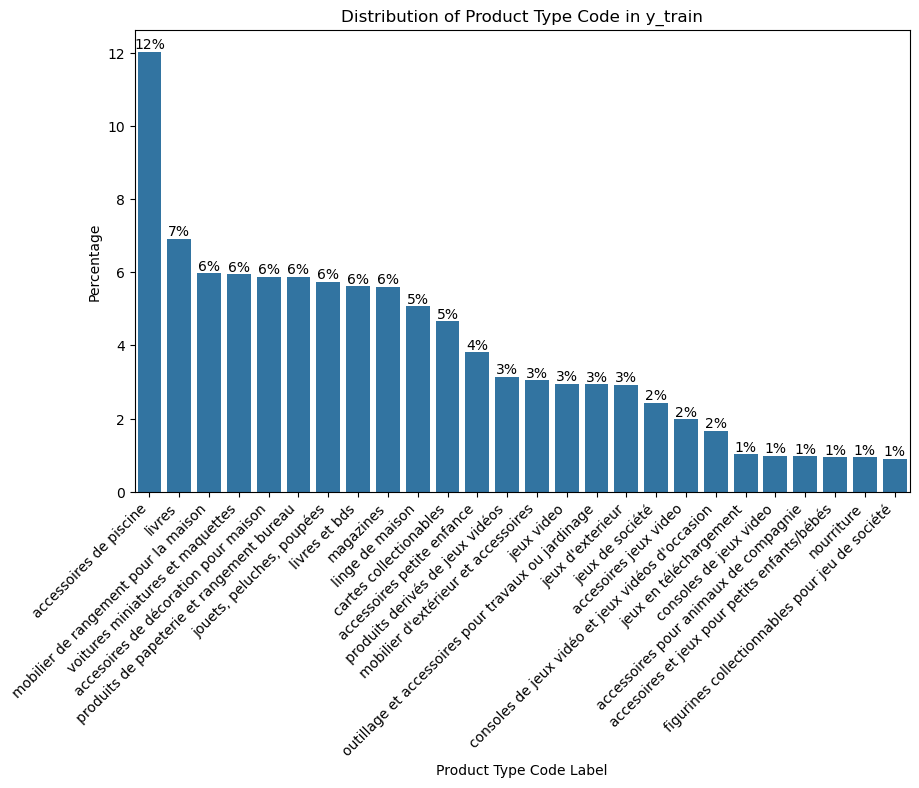

In [262]:
abs_values = y_train['prdtypecode_label'].value_counts(ascending=False)
rel_values = y_train['prdtypecode_label'].value_counts(ascending=False, normalize=True).values * 100
labels = [f'{p[1]:.0f}%' for p in zip(abs_values, rel_values)]

# Histogramme de la distribution des codes de type de produit dans y_train
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=y_train, x='prdtypecode_label', order=y_train['prdtypecode_label'].value_counts().index, stat='percent')
ax.bar_label(container=ax.containers[0], labels=labels)

plt.title('Distribution of Product Type Code in y_train')
plt.xlabel('Product Type Code Label')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.show()

Le jeu de données n'est pas équilibré :
- la classe 2583 (accessoires de piscine) est plus représentée que les autres avec 12% du jeu de données
- les classes 1560 (mobilier de rangement pour la maison), 1300 (voitures miniatures et maquettes), 2060 (accesoires de décoration pour maison), 2522 (produits de papeterie et rangement bureau), 1280 (jouets, peluches, poupées), 2403 (livres et bds), 2280 (magazines) suivent ensuite avec 6% chacune seulement
- les classes les moins représentées 2905 (jeux en téléchargement), 60 (consoles de jeux video), 2220 (accessoires pour animaux de compagnie), 1301 (accesoires et jeux pour petits enfants/bébés), 1940 (nourriture), 1180 (figurines collectionnables pour jeu de société) représentent quant à elles 1% chacune

## Analyse des variables disponibles

### Analyse croisée entre la présence de 'description' du produit et la catégorie du produit


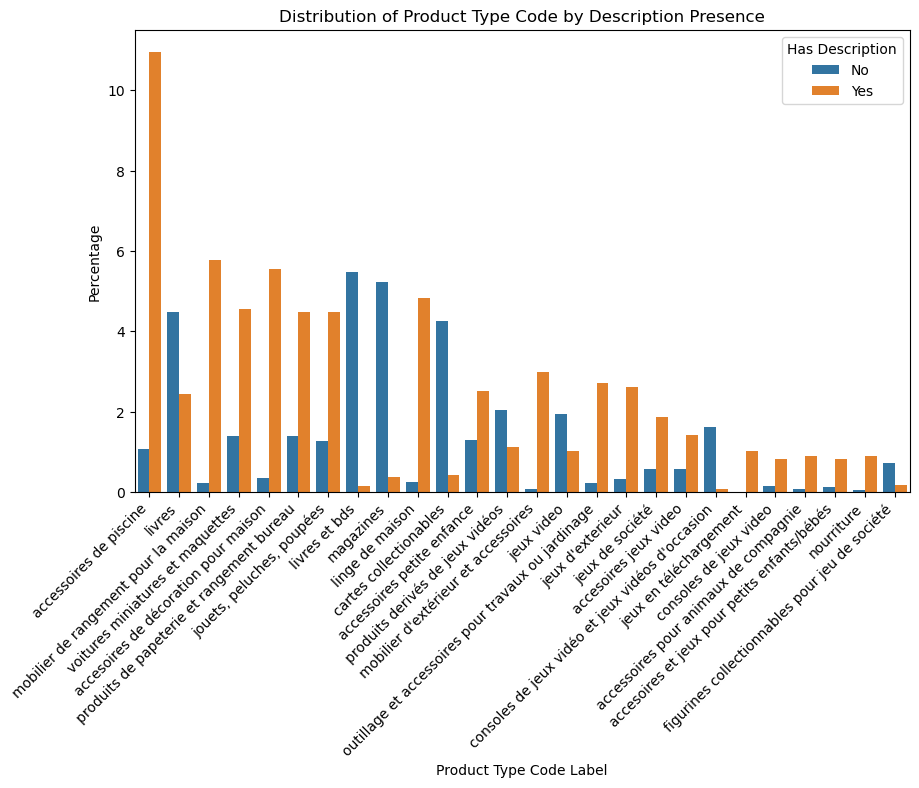

In [263]:
# Affichage de la distribution des codes de type de produit en fonction de la présence de description
plt.figure(figsize=(10, 6))
sns.countplot(data=y_train, x='prdtypecode_label', hue=X_train['has_description'], order=y_train['prdtypecode_label'].value_counts().index, stat='percent')
plt.title('Distribution of Product Type Code by Description Presence')
plt.xlabel('Product Type Code Label')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Has Description', loc='upper right', labels=['No', 'Yes'])
plt.show()

La répartition de produits avec ou sans description n'est pas homogène entre les catégories de produit par rapport au ratio moyen du jeu de données (65% avec et 35% sans description).
Certains produits comme 2403 contiennent majoritairement des produits non décrits alors que d'autres comme 1560 contiennent majoritairement des produits décrits.

### Analyse de la longueur de la variable 'designation'


Text(0.5, 0, 'Designation Length')

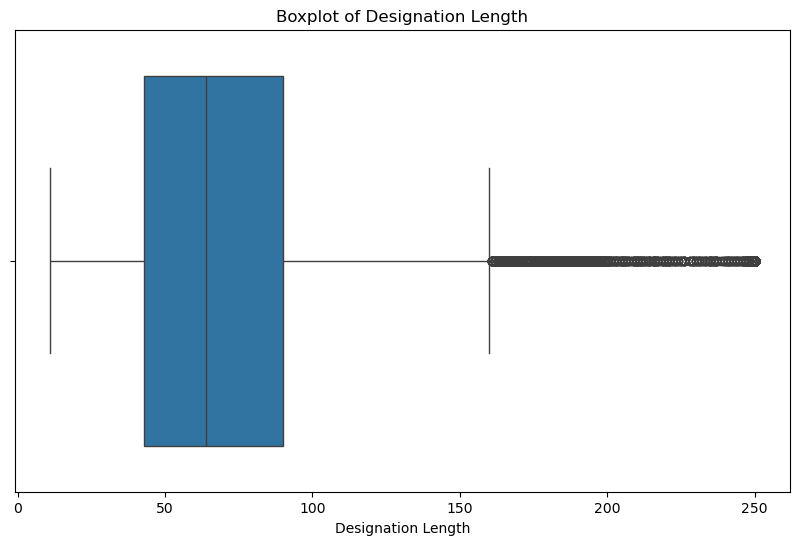

In [264]:
X_train['designation_length'] = X_train['designation'].str.len()

# Boxplot de la longueur de la variable 'designation'
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train, x='designation_length')

plt.title('Boxplot of Designation Length')
plt.xlabel('Designation Length')

In [265]:
X_train['designation_length'].describe()

count    84916.000000
mean        70.163303
std         36.793383
min         11.000000
25%         43.000000
50%         64.000000
75%         90.000000
max        250.000000
Name: designation_length, dtype: float64

On observe que la longueur de designation est très variable avec un min de 11 caractères et un max de 250 caractères.
Sa longueur moyenne est de 70 caractères et la médiane se situe à 64 caractères.
D'après le boxplot, il existe beaucoup d'outliers au dela de 160 caractères.

### Analyse croisée de la catégorie et de la longueur de la 'designation'

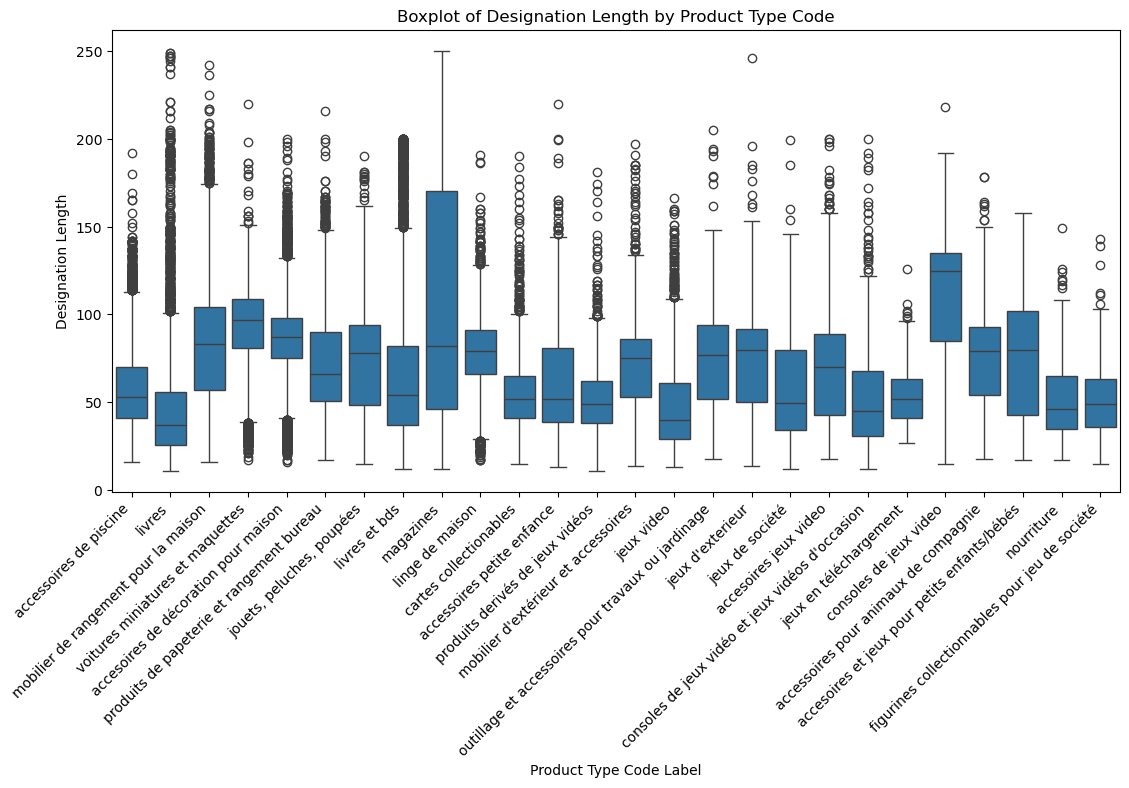

In [266]:
# Boxplot de la longueur de la variable 'designation' par catégorie de produit
plt.figure(figsize=(13, 6))
sns.boxplot(x=y_train['prdtypecode_label'], y=X_train['designation_length'], order=y_train['prdtypecode_label'].value_counts().index)
plt.title('Boxplot of Designation Length by Product Type Code')
plt.xlabel('Product Type Code Label')
plt.ylabel('Designation Length')
plt.xticks(rotation=45, ha='right')
plt.show()

La distribution de la longueur de Designation par catégorie de produit n'est pas homogène.

### Analyse des duplicats de 'designation'

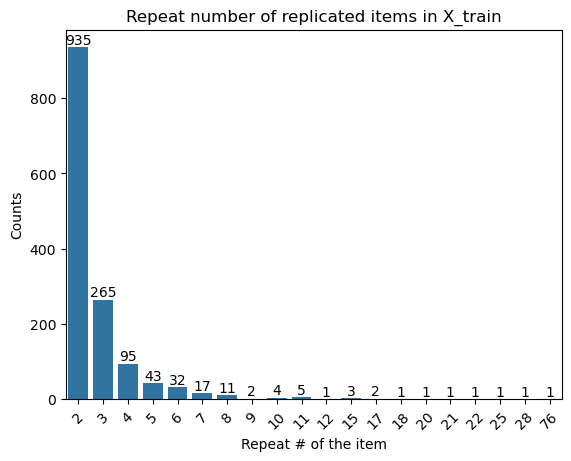

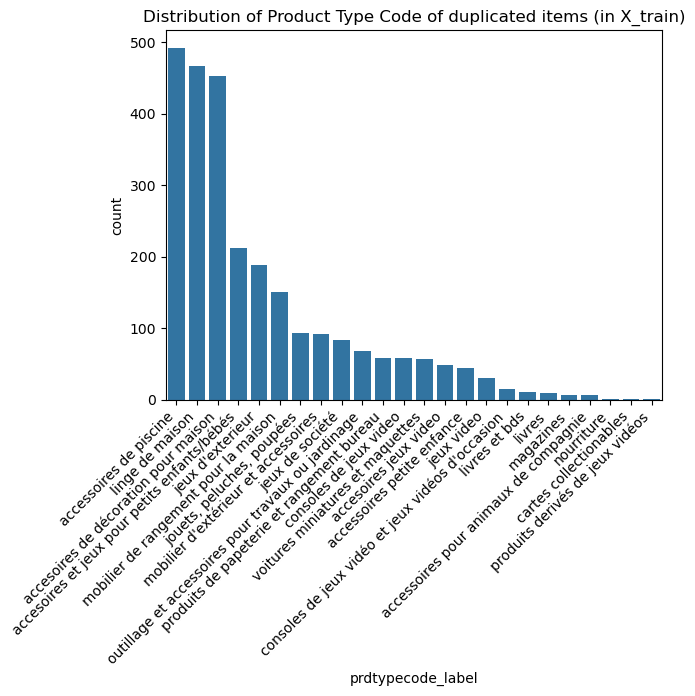

In [267]:
#### Duplicated values frequencies

counts = X_train["designation"].value_counts().reset_index()
counts.columns = ["designation", "repeat"]

repeats = counts['repeat'].value_counts().sort_index().reset_index()

repeats = repeats.iloc[1:]

ax = sns.barplot(data = repeats, x = 'index', y = 'repeat')
ax.bar_label(container = ax.containers[0],  fmt='%d')
plt.xticks(rotation = 45)
plt.xlabel("Repeat # of the item")
plt.ylabel("Counts")
plt.title("Repeat number of replicated items in X_train")
plt.show()


#### Duplicated values' categories

y_duplicated = y_train[X_train.duplicated(subset = ["designation"]) == True]

sns.countplot(data = y_duplicated, x = 'prdtypecode_label', order = y_duplicated['prdtypecode_label'].value_counts().index)
plt.xticks(rotation = 45, ha='right')
plt.title("Distribution of Product Type Code of duplicated items (in X_train)")
plt.show()

On observe de récurrents lignes de 'Designation' avec des fréquences qui varient de 2 à 76 instances: 935 articles se répètent 2 fois, 1 article 76 fois
On observe ces répétitions de Designation dans des catégories différentes

### Analyse de la longueur de la variable 'description'


Text(0.5, 0, 'Description Length')

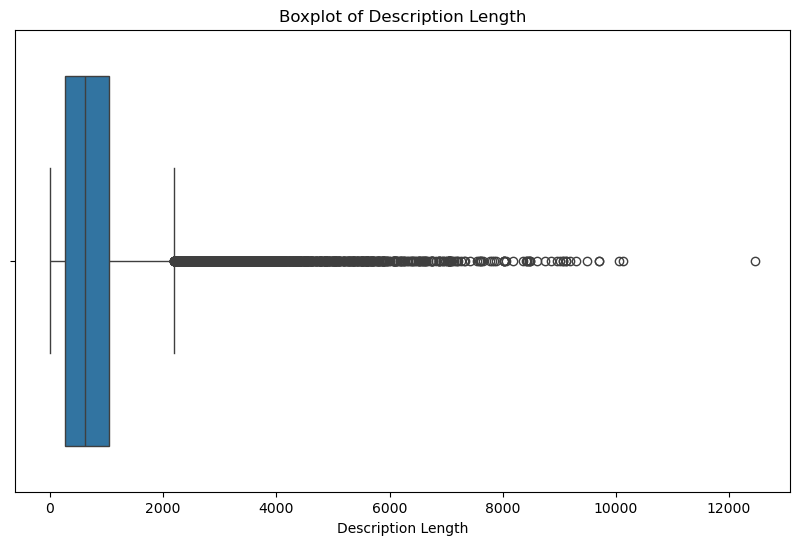

In [268]:
X_train['description_length'] = X_train['description'].str.len()

# Boxplot de la longueur de la variable 'descpription'
plt.figure(figsize=(10, 6))
sns.boxplot(data=X_train, x='description_length')

plt.title('Boxplot of Description Length')
plt.xlabel('Description Length')

In [269]:
X_train['description_length'].describe()

count    55116.000000
mean       808.171692
std        805.462153
min          1.000000
25%        259.000000
50%        626.000000
75%       1034.000000
max      12451.000000
Name: description_length, dtype: float64

On observe que la longueur de description est très variable avec un min de 1 caractères et un max de 12451 caractères.
Sa longueur moyenne est de 808 caractères et la médiane se situe à 626 caractères.
D'après le boxplot, il existe beaucoup d'outliers au dela de 2000 caractères.

### Analyse de la 'description' par catégorie de produit

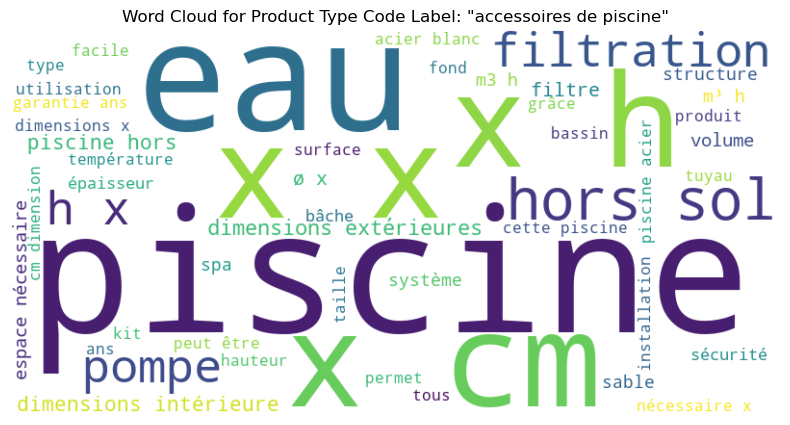

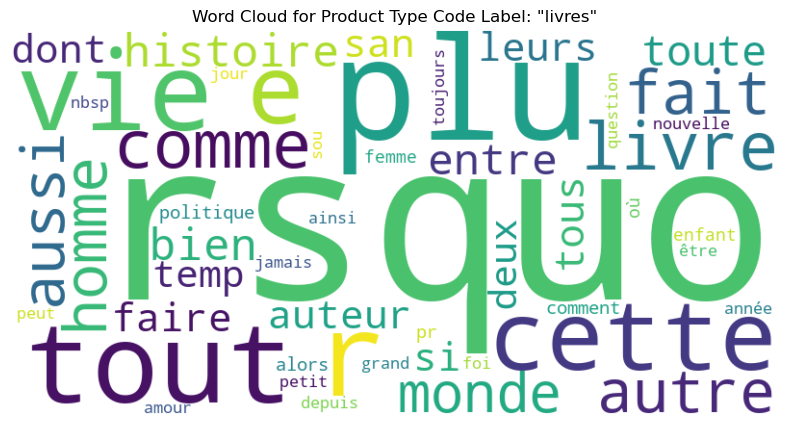

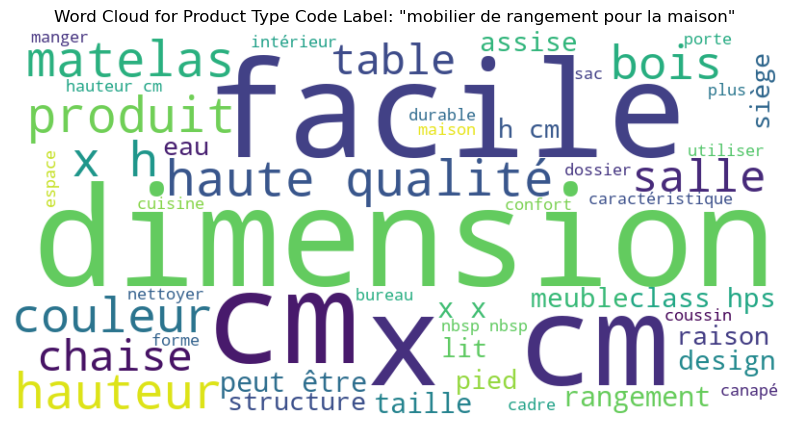

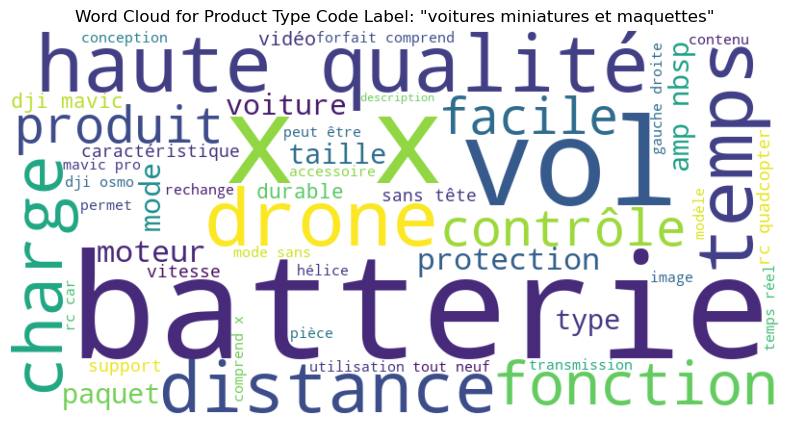

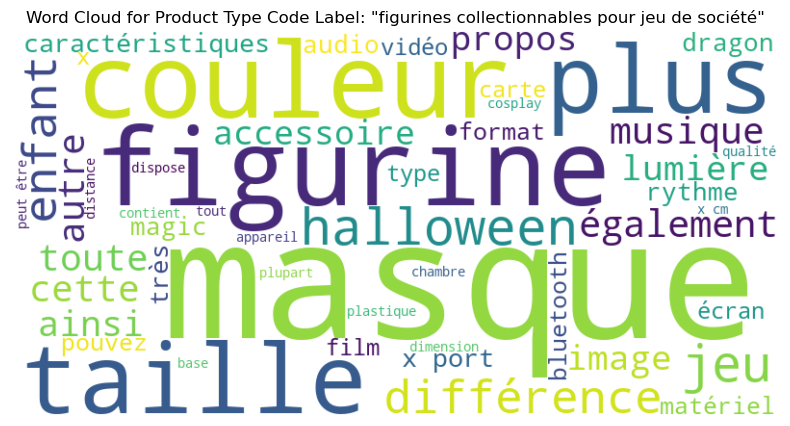

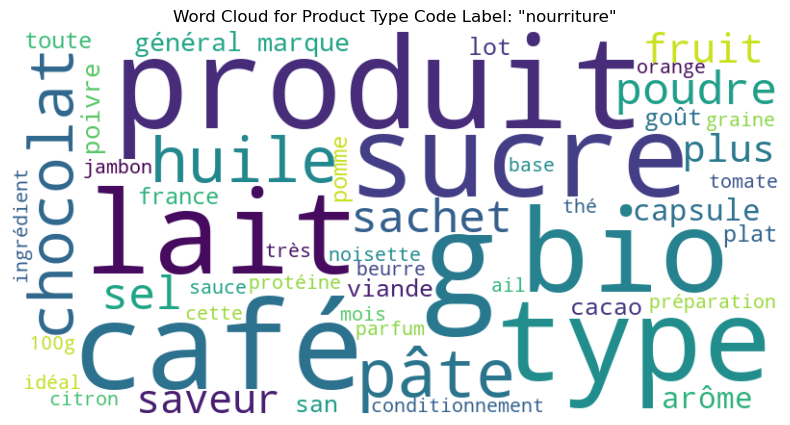

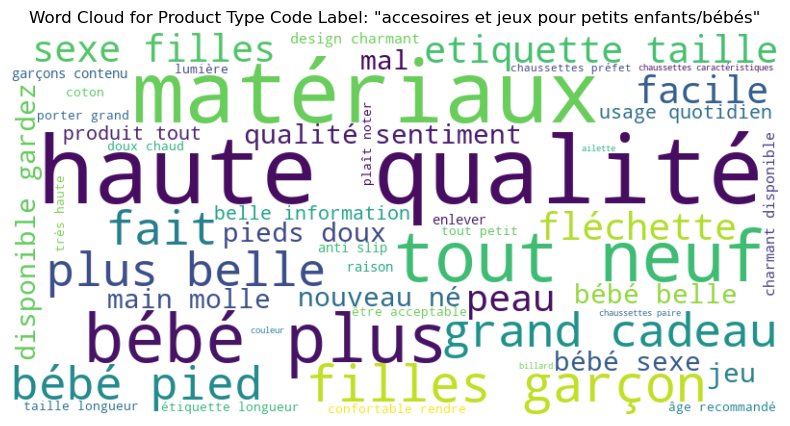

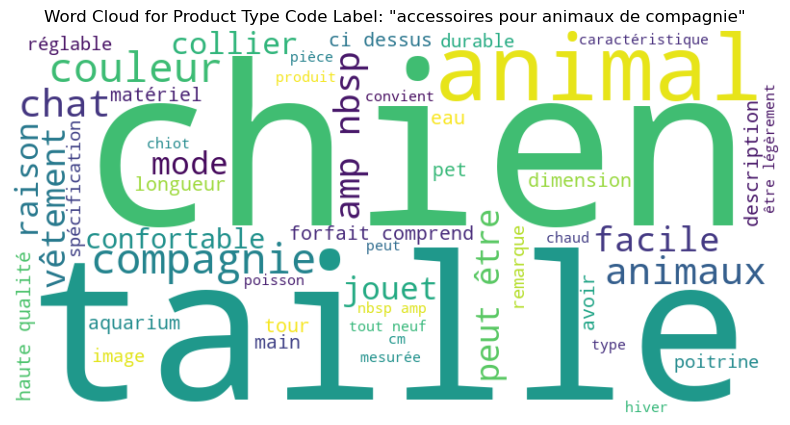

In [270]:
html_stopwords = ['br', 'p', 'div', 'span', 'b', 'i', 'li', 'ul', 'strong', 'em', 'eacute', 'agrave']
final_stopwords = stopwords.words('english') + stopwords.words('french') + html_stopwords

# Récupération des 4 catégories de produits avec le plus et le moins de descriptions pour comparaison
most_descriptions = y_train['prdtypecode_label'].value_counts().nlargest(4).index.tolist()
least_descriptions = y_train['prdtypecode_label'].value_counts().nsmallest(4).index.tolist()

# Concaténation de toutes les descriptions de chaque product label pour la création du nuage de mots
for label in most_descriptions + least_descriptions:
    text = ' '.join(X_train.loc[y_train['prdtypecode_label'] == label, 'description'].dropna().tolist())

    # Nettoyage du texte (apostrophes, ponctuation, etc.)
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    
    # Création du nuage de mots
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, stopwords = final_stopwords).generate(text)
    
    # Affichage du nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for Product Type Code Label: "{label}"')
    plt.show()

Les 4 worclouds des catégories de produits avec le plus de descriptions et les 4 wordclouds de celles avec le moins de descriptions mettent clairement en avant certains termes plus que d'autres.

Cela nous permet d'identifier la catégorie de produit d'une manière sémantique à la lecture des termes mis en exergue : on pourra étudier cette intuition en faisant du deep learning ou encore du NLP pour classifier les catégories.

Sachant que nous avons principalement des données non structurées pour la classification (du texte parfois optionnel et des images), cette approche semble la plus efficace.

## Analyse des images

Chemins des dossiers d’images:

In [271]:
# Paths
image_train_path = "./../data/images/image_train/"
image_test_path = "./../data/images/image_test/"

### Affichage des images

Fonctions utiles pour l’affichage :

In [272]:
# Find a picture path from its imageid and its productid
def image_path(imageid, productid, split="train"):
    if split == "train":
        path = image_train_path
    elif split == "test":
        path = image_test_path
    else:
        raise Exception("split must be train or test.")

    image_path = path + "image_" + str(imageid) + "_product_" + str(productid) + ".jpg"
    return image_path


# Display an image from its path or an image objetc
def display_image(image, print_dim=False):
    if isinstance(image, str):
        img = mpimg.imread(image)
    else:
        img = image

    if print_dim:
        print(f"Image dimensions: {img.shape[0]}x{img.shape[1]} pixels")

    plt.imshow(img)
    plt.axis("off")
    plt.show()
    return


# Display an image from its imageid and its productid
def display_image_df(imageid, productid, split="train", print_dim=False):
    display_image(image_path(imageid, productid, split), print_dim)
    return


# Display an image from a textual row
def display_image_from_row(index_or_row_number, split="train", is_index=True, print_dim=False):
    """
    Display a picture from index (is_index must be True) or
    row number (is_index must be False) of the considered split.
    print_dim allows to print the dimensions of the image.
    """
    if split == "train":
        df = X_train
    elif split == "test":
        df = X_test
    else:
        raise Exception("split must be train or test.")
        
    if is_index:
        display_image_df(df.loc[index_or_row_number, "imageid"], df.loc[index_or_row_number, "productid"], split, print_dim)
    else:
        display_image_df(df.iloc[index_or_row_number, 3], df.iloc[index_or_row_number, 2], split, print_dim)
    return



Quelques exemples d'images avec les fonctions utiles vues précédemment.

Image dimensions: 500x500 pixels


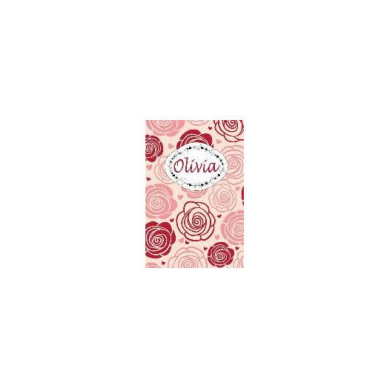

In [273]:
display_image_df(1263597046, 3804725264, "train", print_dim=True)

Image dimensions: 500x500 pixels


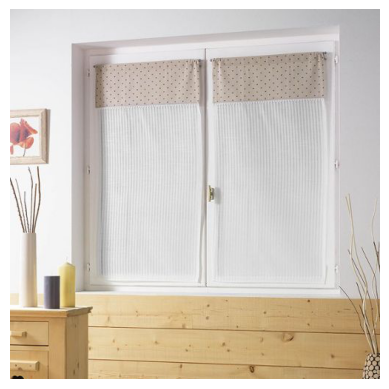

In [274]:
display_image_df(X_train.loc[13, "imageid"], X_train.loc[13, "productid"], "train", print_dim=True)

Image dimensions: 500x500 pixels


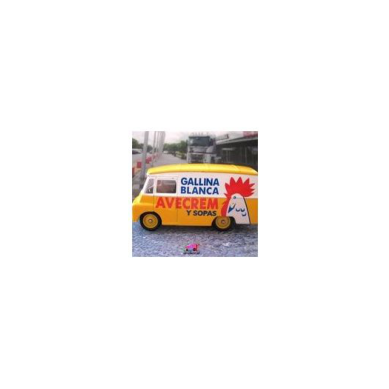

In [275]:
display_image_from_row(15, "test", is_index=False, print_dim=True)

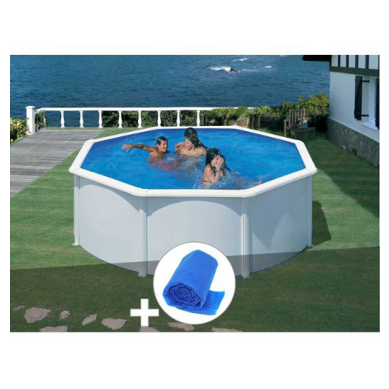

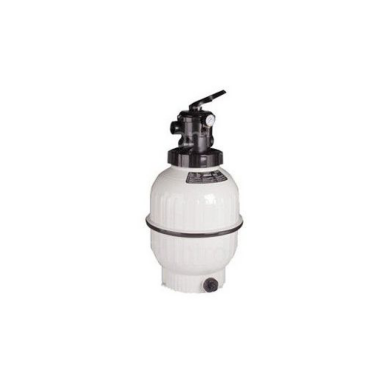

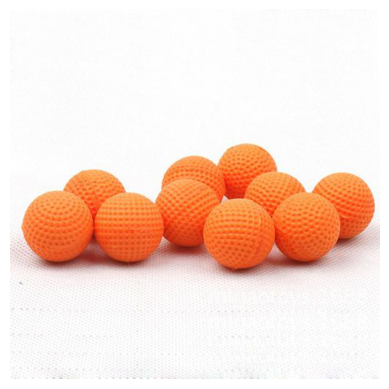

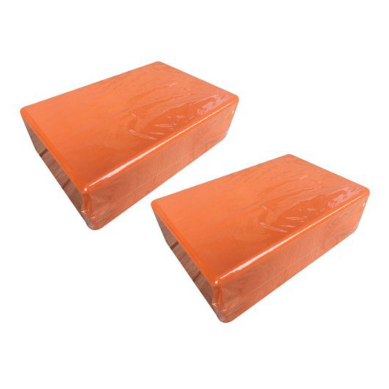

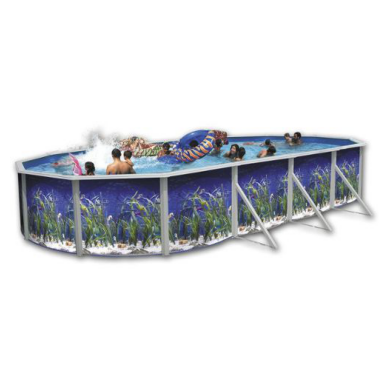

In [276]:
### Random images read with Matplotlib ###
for i in np.random.choice(np.arange(0, len(X_train)), size=5):
    display_image_from_row(i, "train", is_index=False)

On remarque que toutes les images semblent être de la même dimension 500x500 pixels et en couleur. Cependant leurs dimensions utiles sont différentes: la différence est comblée par des bords blancs.

Dans un premier temps, nous vérifierons l'unicité du format des images, puis nous nous intéresserons aux dimensions utiles.

### Affichage de l'image et de la description d'un produit par classe

Product type code: 10
Product type label: "livres"
Designation: Leadership In The New Millennium: Avoiding The Culture Of Corruption
Description: nan
Image dimensions: 500x500 pixels


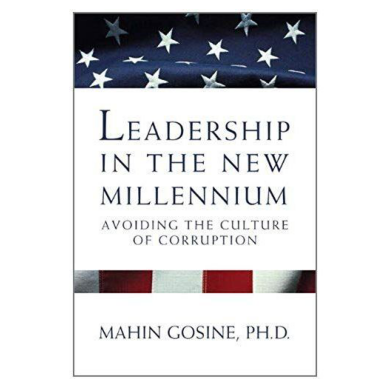

Product type code: 40
Product type label: "jeux video"
Designation: Caesars Palace (Import Us)
Description: nan
Image dimensions: 500x500 pixels


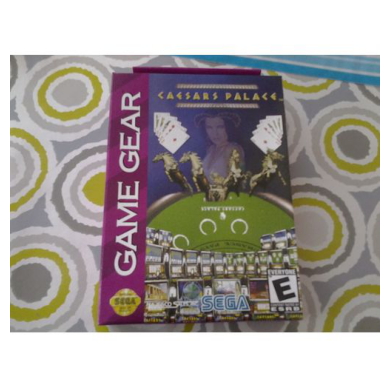

Product type code: 50
Product type label: "accesoires jeux video"
Designation: Prise D'alimentation Et Bouton Power Ps3 Fat (Cechg04)
Description: Pour Sony PlayStation 3 Fat (modèle CECHL04) avec connecteurs et vis.
Image dimensions: 500x500 pixels


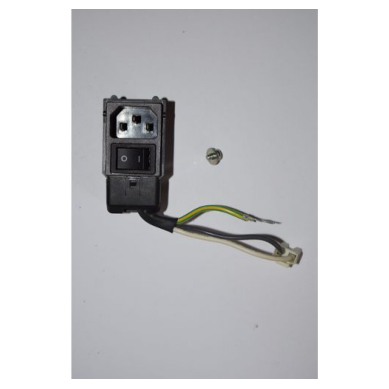

Product type code: 60
Product type label: "consoles de jeux video"
Designation: Console De Jeu Portable Rétro Jeux Vidéo Lecteur Carte Intégré 89 Jeux 8 Bits 2.8in Tft Lcd Écran Pour Tv Familiale
Description: Nom de la marque:JRGK<br />Affichage de couleur:Oui<br />Taille de l&#39;écran:Other<br />Ecran tactile:Pas de<br />Numéro du modèle:PVP3000 0801156<br />Paquet:Oui<br />Communication:USB<br />color:blue red green black blue<br />number:DZV0043X5
Image dimensions: 500x500 pixels


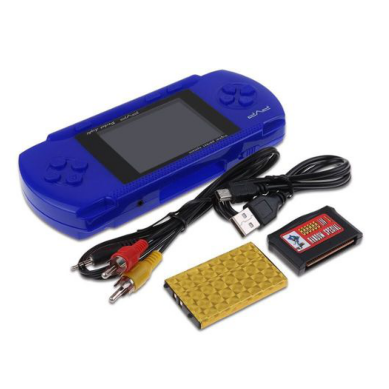

Product type code: 1140
Product type label: "produits derivés de jeux vidéos"
Designation: Dragon Ball Z - Figurine Sangoten - 4.2 Cm
Description: nan
Image dimensions: 500x500 pixels


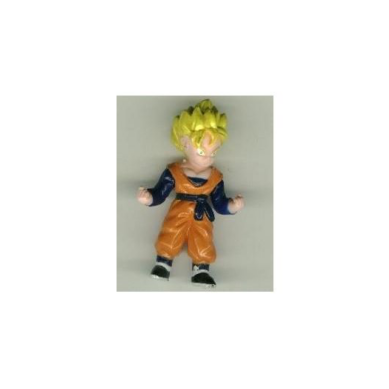

Product type code: 1160
Product type label: "cartes collectionables"
Designation: Yu-Gi-Oh! - Curse Of The Masked Beast - Lon-016 - Commune - Anglais
Description: nan
Image dimensions: 500x500 pixels


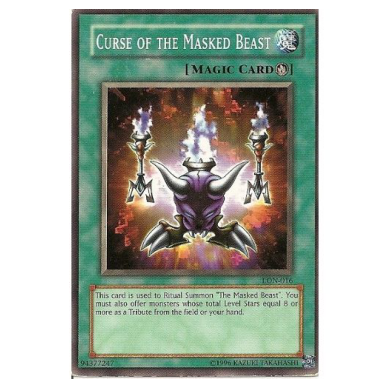

Product type code: 1180
Product type label: "figurines collectionnables pour jeu de société"
Designation: Maître Des Épées De Hoeth Métal Pro Paint Modèle 2
Description: nan
Image dimensions: 500x500 pixels


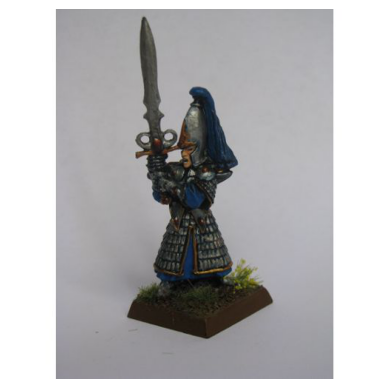

Product type code: 1280
Product type label: "jouets, peluches, poupées"
Designation: Squishy Broken Egg Dinosaur Collection Lente Hausse Squeeze Balle Anti-Stress Toy
Description: Dinosaur spongieuse d&#39;oeuf cassé Parfumé La hausse lente Collection squeeze balle anti-stress Description Toy: Matériel: Elastic environnement PU Taille: 16 * 105 * 105 cm Style: sangles jouet / collections / téléphone portable Motif: Broken Egg Dinosaur Quantité: 1 pcs âge applicable: plus de 6 Squishy ans: hausse lente Le meilleur cadeau de Noël pour vous quand vous regardez ils sont si mignons que vous pouvez vous sentir mieux ou même tous vos mauvais sentiments seront gone.It peut être un remède contre le stress. Cela pourrait être le meilleur Noël que vous présenter jamais donné votre famille charme éponge est vraiment tactile confortable regard réaliste odorante et super Kawai Il est amusant de presser et il semble si grossière! Gross comme vos enfants vont adorer ça! Il aide à rester concentré à l&

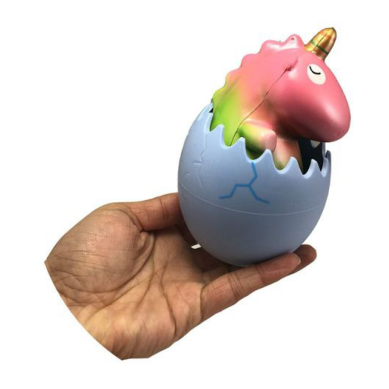

Product type code: 1281
Product type label: "jeux de société"
Designation: Blocs Bébé Forme Sorter Jouets - Enfants Blocs Comprend 15 Formes
Description: Blocs bébé forme Sorter Toy - enfants blocs Comprend 18 formes - couleur de reconnaissance Jouets de forme avec fonction coloré Sorter Cube Box: blocs de construction bébé peuvent déterminer leur capacité d&#39;utiliser et d&#39;apprendre à identifier et à des formes de match construiront motricité fine et l&#39;apprentissage facile à des blocs de préhension - Développer la forme et la reconnaissance couleur - problèmes Foster - compétences en résolution. 15 blocs colorés couvercle tri Forme et 15 formes différentes - Promouvoir la coordination main-oeil. Facile à blocs de préhension - Développer la forme et la reconnaissance des couleurs - problèmes Foster - compétences des problèmes. blocs formes cubiques éducatifs est stimulant et amusant pour les petits - BPA plastique du matériel sans danger pour les tout-petits et babys. 15 bloc

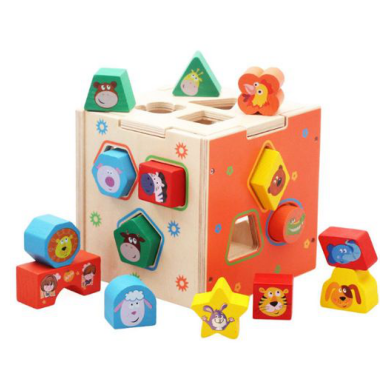

Product type code: 1300
Product type label: "voitures miniatures et maquettes"
Designation: Voiture Nostalgie Americaine N° 5     1/64-American Dream
Description: nan
Image dimensions: 500x500 pixels


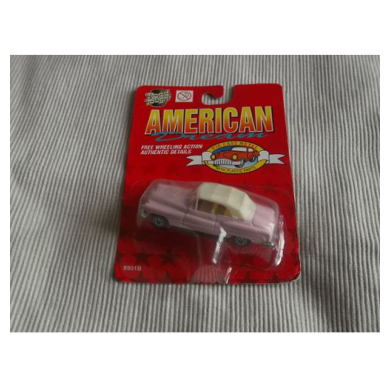

Product type code: 1301
Product type label: "accesoires et jeux pour petits enfants/bébés"
Designation: Baby Foot Stella Home Jaune-Stella
Description: Le baby foot familial sans concession à la qualité.. . Poids 70 kg. Dimensions 158 x 100 x 93 cm. Barres téléscopiques 15 mm de diamètre. Joueurs alu vissés. Amortisseurs caoutchouc. Cages de but tôle laquée. Poignées longues. . Livré avec 5 balles. . Livraison en France Métropolitaine Uniquement. Livraison Directe par le Fabricant en 15 jours environ
Image dimensions: 500x500 pixels


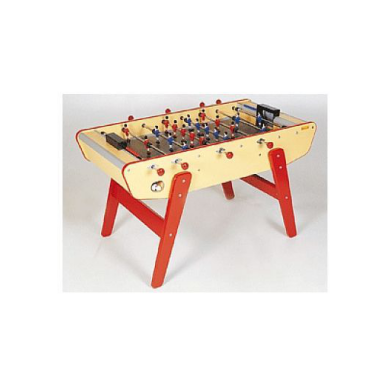

Product type code: 1302
Product type label: "jeux d'exterieur"
Designation: Strawberry Coloré Mélange Nuage Cotton Candy Slime Parfumée Stress Enfants Clay D
Description: 50 g de fraises coloré mélange Nuage Cotton Candy Slime parfumée Stress Enfants Clay Jouet D Description: bave moelleux incroyable et super fun à jouer avec grand remède contre le stress pour les adultes et les enfants Nom du produit: boue nuage décompressé boue flocon de neige Chaque conten obtient une cuillère à soupe de confettis qui ressemble merveilleux poids net: 50g Inclure: 1 pc Slime Toy
Image dimensions: 500x500 pixels


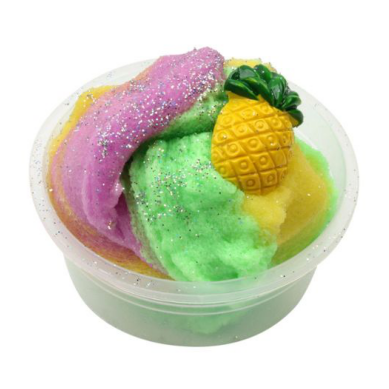

Product type code: 1320
Product type label: "accessoires petite enfance"
Designation: Tigex 3 Aspergeurs Nemo
Description: TIGEX 3 Aspergeurs Nemo<br />Set de 3 personnages grand format - Personnages iconiques en adéquation parfaite avec le segment du bain - Design exclusif -Matière souple.
Image dimensions: 500x500 pixels


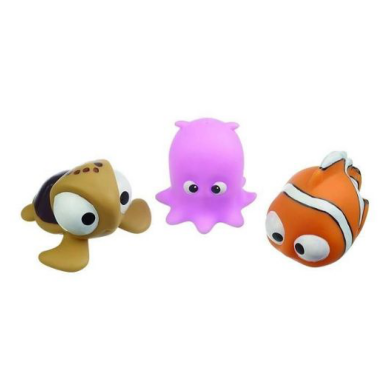

Product type code: 1560
Product type label: "mobilier de rangement pour la maison"
Designation: Chaise Cassiopea Contemporaine Gris Clair - Pour Le Bureau Salon Cuisine Chambre Table
Description: Chaise élégante et fonctionnelle. Est la solution idéale pour meubler votre maison avec style en assurant détente et confort. Idéal comme mobilier pour le salon de la maison. Kit de montage inclus faciles à nettoyer faciles à assembler.   Couleur: Gris Clair; Matériel: Métal Tissu; Dimensions: 66x58x83 cm - Vous recevrez votre article dans les 7 jours
Image dimensions: 500x500 pixels


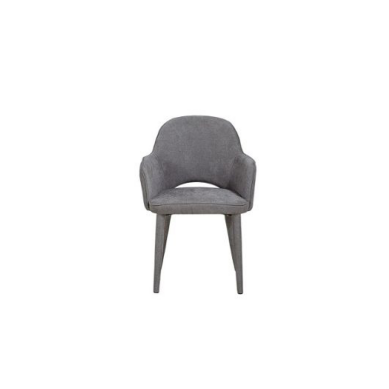

Product type code: 1920
Product type label: "linge de maison"
Designation: Simplicité Élégante En Peluche Courte Couverture Canapé Throw Taie D'oreiller Home Decor Zheng13357
Description: Simplicité élégante peluche courte couverture Canapé Coussin Case Home Decor Caractéristiques: Style: simple mode parfait pour place sur le canapé un café une bibliothèque un magasin de livres partie club. Matériel: peluche courte Forme: Carré Taille: 45 cm * 45 cm Type: Taie d&#39;oreiller S&#39;il vous plaît permettre une légère déviation de la couleur et de la mesure! S&#39;il vous plaît comprendre merci! Forfait: Le forfait comprend: 1pc Taie d&#39;oreiller
Image dimensions: 500x500 pixels


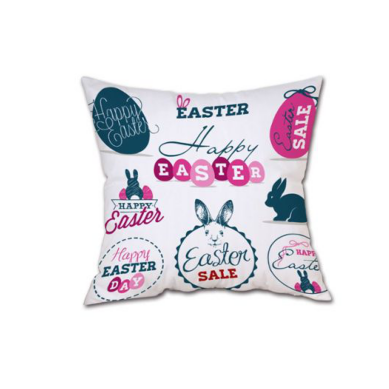

Product type code: 1940
Product type label: "nourriture"
Designation: Mr.Freeze Standard "Classic" 50ml
Description: Carton de 150 pièces<br>La plus grande marque de bâtons glacés du marché dans son format traditionnel (congelable et décongelable à volonté). Avec de nombreux parfums assortis (cola fraise orange framboise) pour des pauses fruitées délicieuses à tout moment de la journée! [Carton de 150 pièces] Ingrédients: Eau Sucre acidifiant : acide citrique agent stabilisant : pectine concentré de fruits et légumes pour la couleur : carthame citron pomme arômes agent de conservation : sorbate de potassium colorants.
Image dimensions: 500x500 pixels


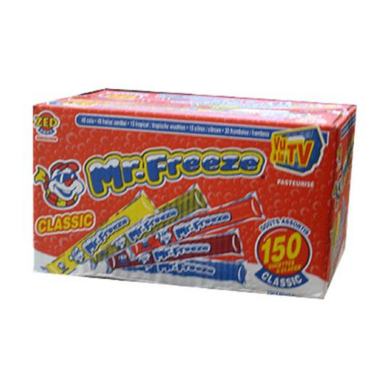

Product type code: 2060
Product type label: "accesoires de décoration pour maison"
Designation: Ornement Crâne De Buffle Nickel Brut Sur Pied
Description: Ornement crâne de buffle nickel brut sur piedTrès bel ornement de <strong>crâne de buffle en nickel brut</strong> à poser grâce à son pied. Apportez une réelle originalité à votre intérieur avec ce grand crâne de buffle en métal très tendance.Informations sur le crâne buffle nickel brut sur pied :<ul><li>Dimensions : 57 x 12 x 54 cm</li><li>Matière : nickel</li><li>Couleur : nickel (gris argent)</li><li>Poids : 35 kg</li></ul>
Image dimensions: 500x500 pixels


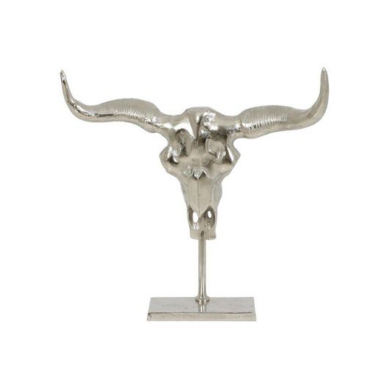

Product type code: 2220
Product type label: "accessoires pour animaux de compagnie"
Designation: Laisse Aventura Réfléchissant En Nylon Pour Chiens 120 Cm X 25 Mm Orange
Description: nan
Image dimensions: 500x500 pixels


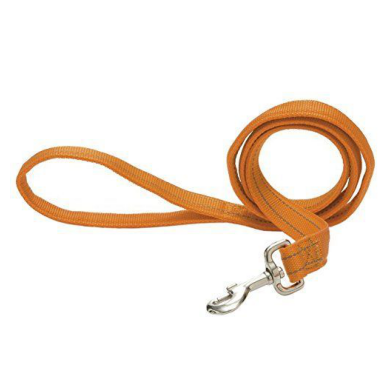

Product type code: 2280
Product type label: "magazines"
Designation: Parisien (Le) N° 15306 Du 22/11/1993 - L Hiver Meurtrier -
Description: nan
Image dimensions: 500x500 pixels


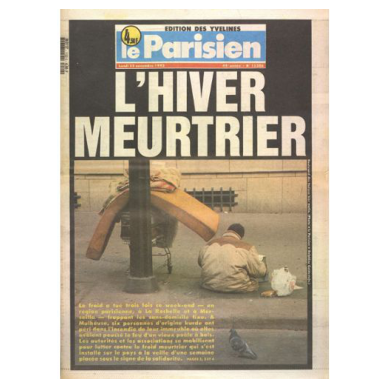

Product type code: 2403
Product type label: "livres et bds"
Designation: Soul Eater - Atsushi Ohkubo - Tomes 1 2 3 4 5 6 7 8 9 10 11 12 13 - Kurokawa (Shonen)
Description: nan
Image dimensions: 500x500 pixels


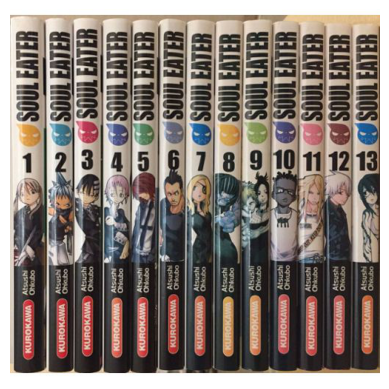

Product type code: 2462
Product type label: "consoles de jeux vidéo et jeux vidéos d'occasion"
Designation: Panzer General Ii Jeu Pc Big Box Grosse Boite
Description: nan
Image dimensions: 500x500 pixels


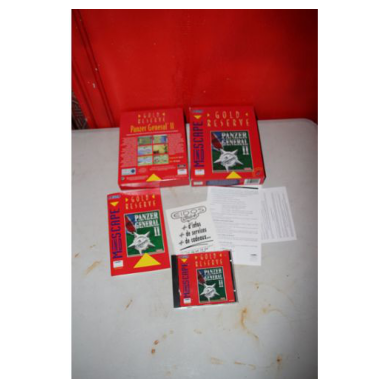

Product type code: 2522
Product type label: "produits de papeterie et rangement bureau"
Designation: Porte-Cylindre Pen Charge Votre Stylo Préféré Et Crayon Sur Le Bureau Pen @Yahuoa168
Description: Cylindre Pen Holder charge votre stylo préféré et crayon sur le bureau Pen produit de vente Point: Ce porte-stylo rond ce porte-stylo unique conserve vos matériaux d&#39;écriture verrouillés et chargés contenir jusqu&#39;à 6 stylos ou des crayons. Peut contenir vos stylos préférés et plus Le porte-stylo de cylindre est assez grand pour contenir de grands enclos Sharples marqueurs ciseaux stylos crayons ouvre-lettres et beaucoup d&#39;autres widgets de bureau. Votre Compagnon Office Un complément parfait à votre bureau à domicile bureau de travail et mancave le porte-stylo cylindre du pistolet est l&#39;accessoire de bureau non létal parfait et cadeau pour amateurs chasseurs et plus. Le cadeau parfait pour nos hommes Les femmes dans les spécifications uniformes: Matériel: Aluminium Note: En 

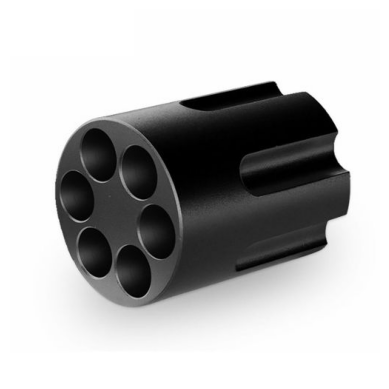

Product type code: 2582
Product type label: "mobilier d'extérieur et accessoires"
Designation: Butterfly Silicone Leakproof Coffee Mug Suction Lid Cap Airtight Seal Cup Coverhpp3150
Description: Butterfly Silicone Leakproof Coffee Mug Suction Lid Cap Airtight Seal Cup Cover Feature:100% brand new and high qualityMaterial: Silicone Size:Approx. 11cm Color: Green/Blue/Pink/Yellow Detachable butterfly handle for convenient use. Safe and high quality material use with reassurance. Dustproof and leakage-proof Great for drinking glasses/cup tea cup useThere is 1 ~ 2cm error because munual measurement Posted by horizontal.All product images are in kind lighting computer monitor differences result in chromatic aberration with the actual products. the final colors will prevail in kind. Package Include: 1Pc Cup Lid
Image dimensions: 500x500 pixels


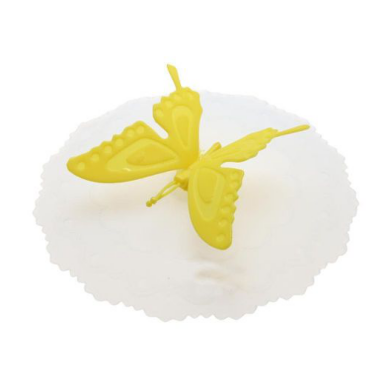

Product type code: 2583
Product type label: "accessoires de piscine"
Designation: Set de 15 Éponges d?Écume Produits Pools Absorbante pour Huile T Box Corporelles MagiDeal
Description: <p><b>La description:</b></p><br /><p> Coffre-fort: en cas de glissade vous pouvez facilement voir l&#39;éponge flottante à la surface de l&#39;eau. <br /> Facile à utiliser: jetez l&#39;éponge du spa et laissez la pompe de filtration fonctionner pendant un moment puis laissez-la flotter librement (retournez-la de temps à autre). <br /> Super absorbant: l&#39;éponge absorbant l&#39;huile T Box absorbe l&#39;écume inanimée la lotion de bronzage les huiles corporelles les cosmétiques le pollen etc. sans absorber l&#39;eau. <br /> Kit de maintenance du spa: en éloignant le filtre des résidus inertes d?huiles et d?huiles il permet de maximiser la durée de vie du filtre et de réduire les coûts de maintenance. <br /> Aide à éliminer la saleté inanimée formée dans les spas les bains à jets et les spas. </p><br 

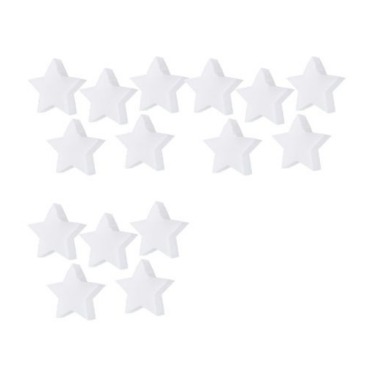

Product type code: 2585
Product type label: "outillage et accessoires pour travaux ou jardinage"
Designation: Panneau mural 3D WallArt Ellipses 3m2
Description: Présentation : Panneau mural 3D WallArt Ellipses 3m2 conçu en fibres de canne à sucre ces panneaux décorent et donnent du style à vos murs. Ils sont idéals pour décorer votre intérieur de manière moderne et design. Elu produit écologique le plus innovant en 2009 ces panneaux peuvent être peints de toutes les couleurs à l'aide de peinture acrylique. Les 20 modèles disponibles vous permettent d'avoir le choix pour decorer tous vos espaces. Caractéristiques : Packaging : 12 plaques soit 3m2 Dimension : 500x500mm avec +/-05mm de chaque côté Poids : 275g Epaisseur : +/- 175mm (Tolérence de 05mm) Epaisseur du panneau : +15mm Matériel : Fibre de canne à sucre Surface : lisse Inflammable : Classe C Acoustique : Propriétés d'isolation acoustique Conseil : Si un panneau est abîmé il est possible d'appliquer un enduit ou de remplacer le p

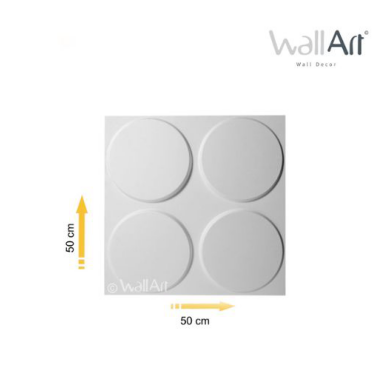

Product type code: 2705
Product type label: "livres"
Designation: Deux Papas Très Bien
Description: nan
Image dimensions: 500x500 pixels


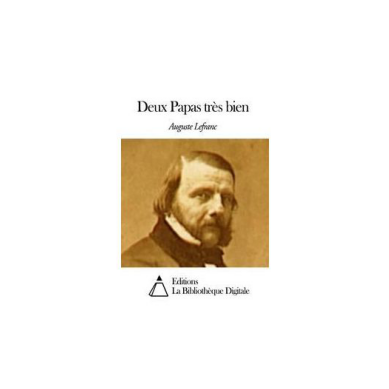

Product type code: 2905
Product type label: "jeux en téléchargement"
Designation: Tom Clancy's Ghost Recon Future Soldier - Arctic Strike Map Pack (Dlc 1) - Jeu En Téléchargement
Description: <br /> NOTE : Nécessite le jeu original <b>Tom Clancy&#39;s Ghost Recon Future Soldier?</b> pour fonctionner. <br /><br /><br /> <strong>À PROPOS DU JEU</strong>  Quand vous êtes abattu dans ce mode vous êtes envoyé en prison. Votre équipe peut libérer un équipier à chaque ennemi vaincu ou tous les équipiers en prison si elle accomplit un objectif. La partie prend fin quand tous les joueurs d&#39;une équipe sont en prison. <br /><br /><br /> <strong>CARACTÉRISTIQUES</strong>  <b>Une carte Guérilla « Base arctique &#39;.</b><br /><br /> <b>Un nouveau mode multijoueur « Prison &#39;.</b><br /><br /> <b>Trois cartes multijoueur Opposition.</b> <ul><li>Émeute : Ghosts et Bodark se disputent le contrôle d&#39;un no-man&#39;s-land déserté.</li><li>Horizon : ce toit de gratte-ciel est un cauchemar pour l

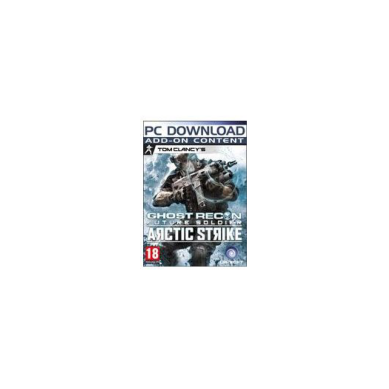

In [277]:
# Random selection of one index in y_train for each type of product code
random_indices = y_train.groupby('prdtypecode').apply(lambda x: x.sample(1)).index.get_level_values(1).tolist()

# Display the image for the randomly selected indices
for idx in random_indices:
    print(f"Product type code: {y_train.loc[idx, 'prdtypecode']}")
    print(f"Product type label: \"{y_train.loc[idx, 'prdtypecode_label']}\"")
    print(f"Designation: {X_train.loc[idx, 'designation']}")
    print(f"Description: {X_train.loc[idx, 'description']}")

    display_image_from_row(idx, "train", is_index=True, print_dim=True)

### Vérification du format

Associons à chaque produit le path de l'image qui lui correspond.

In [278]:
X_train["imagepath"] = X_train.apply(lambda row: image_path(row["imageid"], row["productid"], "train"), axis=1)
X_test["imagepath"] = X_test.apply(lambda row: image_path(row["imageid"], row["productid"], "test"), axis=1)

Le dataset traincontient autant que d'images que de produits (84916). On pose alors l'hypothèse très probable que chaque produit a bien une image associée, même si elle est vide (entièrement blanche, ce qu'on testera plus tard), ce qui correspondrait à une valeur nulle.

Les chargements ou traitements d'image étant assez lourds, nous décidons de prendre seulement un échantillon de 1000 images aléatoires (mais reproductible) pour notre première analyse, et nous gardons les produits associées en textuel de côté.

In [279]:
X_train_sample = X_train.sample(n=1000, random_state=42)

X_img_sample = X_train_sample["imagepath"]
X_img_sample.head()

36138    ./../data/images/image_train/image_1100082580_...
68630    ./../data/images/image_train/image_1139624392_...
36172    ./../data/images/image_train/image_1271697301_...
9830     ./../data/images/image_train/image_1313204688_...
28422    ./../data/images/image_train/image_518749844_p...
Name: imagepath, dtype: object

On l'enrichit avec d'autres informations.

In [280]:
def shape_from_path(image_path):
    img = mpimg.imread(image_path)
    return img.shape

In [281]:
X_img_sample = pd.concat([
    X_img_sample.rename("image_path"),
    X_img_sample.apply(shape_from_path).rename("image_shape")
], axis=1)

In [282]:
data_info(X_img_sample)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 36138 to 65534
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_path   1000 non-null   object
 1   image_shape  1000 non-null   object
dtypes: object(2)
memory usage: 23.4+ KB




image_path    image_shape
36138  ./../data/images/image_train/image_1100082580_...  (500, 500, 3)
68630  ./../data/images/image_train/image_1139624392_...  (500, 500, 3)
36172  ./../data/images/image_train/image_1271697301_...  (500, 500, 3)
9830   ./../data/images/image_train/image_1313204688_...  (500, 500, 3)
28422  ./../data/images/image_train/image_518749844_p...  (500, 500, 3)

Vérifions que dans le dataset (au moins dans l'échantillon), toutes les images sont au même format.

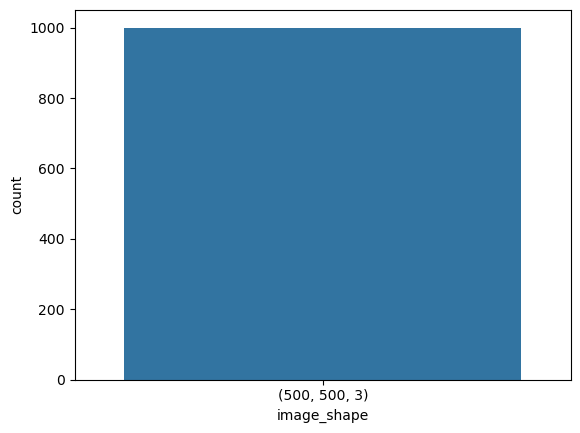

In [283]:
# Compter les occurrences des formats
X_img_sample['image_shape'] = X_img_sample['image_shape'].astype(str)
sns.countplot(data=X_img_sample, x='image_shape', order=X_img_sample['image_shape'].value_counts().index)
plt.show()

On a bien uniquement des images en 500x500 pixels et en RGB.

### Content Box: la zone utile sans les bords blancs

Déterminons maintenant la "zone utile", c'est-à-dire l'image sans les bords blancs.

In [284]:
def get_content_box(image_path, seuil_ratio=0.99):
    """
    Détecte la bounding box du contenu non blanc d'une image.

    Args:
        image_path (str): chemin vers l'image.
        seuil (float): seuil pour considérer un pixel blanc (entre 0 et 1).
    Returns:
        tuple: dimensions de la zone utile (largeur, hauteur), coordonnées x_min, y_min, x_max, y_max.
    """
     
    # Charge l'image (forme: H x W x C), valeurs normalisées [0, 1]
    img = mpimg.imread(image_path)

    # img peut être chargé normalisé (valeurs de couleurs entre 0 et 1) ou en [0, 255]
    # On adapte donc le seuil en fonction de la valeur maximale des pixels
    seuil = seuil_ratio * img.max()

    # Crée un masque des pixels "non blancs"
    # Ici, on considère qu'un pixel est blanc si ses 3 canaux sont > seuil (proche de 1)
    non_white = np.any(img < seuil, axis=2)
   
    # Trouve les coordonnées de la zone utile
    coords = np.argwhere(non_white)

    if coords.size == 0:
        # "Image entièrement blanche."
        return None

    # Récupère les limites du contenu utile
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)

    width = x_max - x_min + 1
    height = y_max - y_min + 1

    # print(f"Taille utile : {width} x {height} pixels")
    # print(f"Bounding box : x={x_min}, y={y_min}, largeur={width}, hauteur={height}")

    return ((width, height), x_min, y_min, x_max, y_max)

Image dimensions: 500x500 pixels


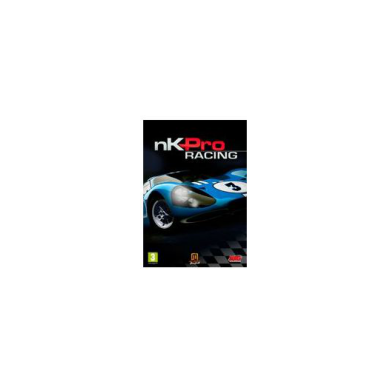

(144, 208) 176 144 319 351


In [285]:
# Exemple d’utilisation
display_image(X_img_sample.iloc[0]["image_path"], print_dim=True)
dim, x_min, y_min, x_max, y_max = get_content_box(image_path=X_img_sample.iloc[0]["image_path"])
print(dim, x_min, y_min, x_max, y_max)

In [286]:
# Charge l'image complète et retourne l'image utile à partir de la bounding box
def load_content_from_box(image_path, x_min, y_min, x_max, y_max):
    # Charge l'image complète
    img = mpimg.imread(image_path)

    # Attention : dans numpy, l'ordre est img[hauteur, largeur] donc img[y_min:y_max+1, x_min:x_max+1]
    img_cropped = img[y_min:y_max+1, x_min:x_max+1, :]
    return img_cropped


def load_content_box_from_image(image_path):
    """
    Charge l'image complète et retourne l'image utile.
    
    Args:
        image_path (str): chemin vers l'image.
    
    Returns:
        np.ndarray: image utile sans les bords blancs.
    """
    dim, x_min, y_min, x_max, y_max = get_content_box(image_path)
    if dim is None:
        return None  # Image entièrement blanche
    
    return load_content_from_box(image_path, x_min, y_min, x_max, y_max)

Image dimensions: 208x144 pixels


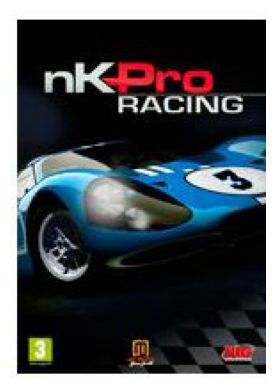

In [287]:
# Exemple d'utilisation
display_image(load_content_box_from_image(X_img_sample.iloc[0]["image_path"]), print_dim=True)

Remplissons notre Dataframe d'échantillon d'images avec ces informations.

In [288]:
df_content_box = X_img_sample["image_path"].apply(get_content_box).apply(pd.Series)
df_content_box.columns = ["content_dim", "x_min", "y_min", "x_max", "y_max"]

X_img_sample["content_dim"] = df_content_box["content_dim"]
X_img_sample[["content_width", "content_height"]] = X_img_sample["content_dim"].apply(pd.Series)
X_img_sample[["x_min", "y_min", "x_max", "y_max"]] = df_content_box[["x_min", "y_min", "x_max", "y_max"]]

In [289]:
data_info(X_img_sample)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 36138 to 65534
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_path      1000 non-null   object
 1   image_shape     1000 non-null   object
 2   content_dim     1000 non-null   object
 3   content_width   1000 non-null   int64 
 4   content_height  1000 non-null   int64 
 5   x_min           1000 non-null   int64 
 6   y_min           1000 non-null   int64 
 7   x_max           1000 non-null   int64 
 8   y_max           1000 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 110.4+ KB




image_path    image_shape  \
36138  ./../data/images/image_train/image_1100082580_...  (500, 500, 3)   
68630  ./../data/images/image_train/image_1139624392_...  (500, 500, 3)   
36172  ./../data/images/image_train/image_1271697301_...  (500, 500, 3)   
9830   ./../data/images/image_train/image_1313204688_...  (500, 500, 3)   
28422  ./../data/images/image_train/image_518749844_p...  (500, 500, 3)   

      content_dim  content_width  content_height  x_min  y_min  x_max  y_max  
36138  (144, 208)            144             208    176    144    319    351  
68630  (193, 208)            193             208    176    144    368    351  
36172  (500, 500)            500             500      0      0    499    499  
9830   (395, 500)            395             500     53      0    447    499  
28422  (368, 500)            368             500     64      0    431    499

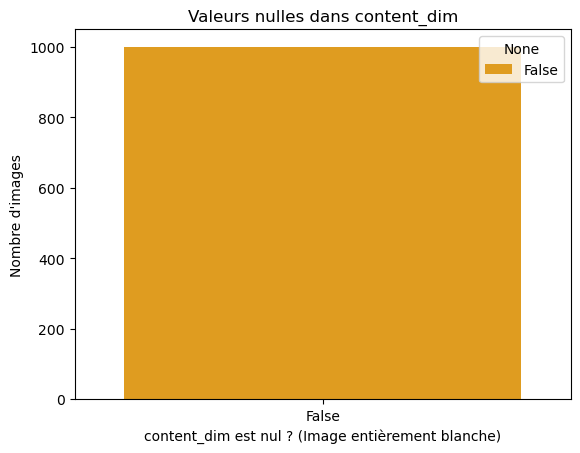

In [290]:
content_dim_value_counts = X_img_sample["content_dim"].isnull().value_counts()
sns.barplot(
    x=content_dim_value_counts.index,
    hue=content_dim_value_counts.index,
    y=content_dim_value_counts.values,
    palette={True: "blue", False: "orange"}
)
plt.title("Valeurs nulles dans content_dim")
plt.xlabel("content_dim est nul ? (Image entièrement blanche)")
plt.ylabel("Nombre d'images")
plt.show()

Quand une image est entièrement blanche, alors le content_dim est nul. Ce n'est pas le cas ici alors aucune de nos images (donc des images liées aux produits) n'est "nulle".

Il ne s'agit que d'un échantillon, même s'il a été choisi aléatoirement, cela ne nous donne pas la proportion totale, mais cela nous sert simplement d'idée. On supposera ainsi qu'aucune image n'est entièrement blanche.

### Uniformité des données d'image et préparation

On s'intéresse aux dimensions de la content box.

False    525
True     475
dtype: int64


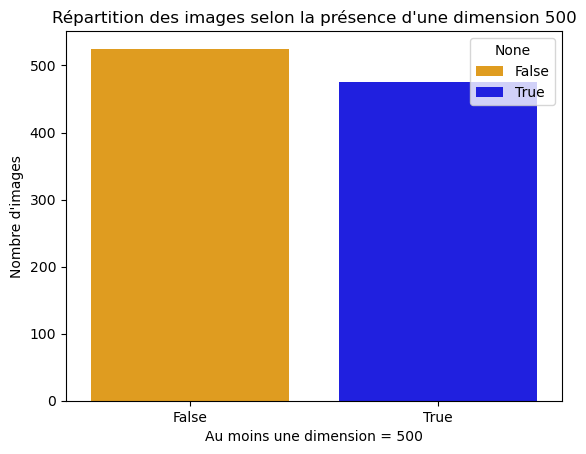

In [291]:
# On considère qu'une image est "complète" si au moins une de ses dimensions (largeur ou hauteur) est égale à 500 pixels.
# Création d'une colonne booléenne "image_complete" : True si width ou height = 500
image_complete = (X_img_sample['content_width'] == 500) | (X_img_sample['content_height'] == 500)
print(image_complete.value_counts())
# Countplot
sns.countplot(x=image_complete, hue=image_complete, palette={True: "blue", False: "orange"})

plt.xlabel("Au moins une dimension = 500")
plt.ylabel("Nombre d'images")
plt.title("Répartition des images selon la présence d'une dimension 500")
plt.show()

On constate que 52,5% n'a aucune de ses dimensions égale à 500. Beaucoup d'images n'occupent donc pas l'espace disponible, dans aucune des dimensions: nous pourrions donc les étendre.

En effet, la zone utile (qui serait également la zone utile pour l'apprentissage par un modèle) est bien différente selon les images.
Nous pourrions alors nous intéresser à appliquer des algorithmes de Computer Vision pour combler cette différence et harmoniser les données et les vecteurs qui en résulteraient.
L'exemple le plus simple serait d'utiliser un filtre avec des masques pour agrandir les images jusqu'à atteindre un des bords.

Il serait plus difficile pour un modèle s'entraînant sur des images d'être pertinent si certaines données sont des matrices creuses (pleine de blanc) et d'autres sont pleines.

Par exemple, deux piscines prenant toute l'image auraient plus d'informations communes dans leurs pixels qu'une piscine en grand, et une piscine en toute petite (majorité de pixels blancs).

Nous aurions pu également visualiser l'ensemble des différents format de Content box mais cela serait bien trop éparpillé et le traitement final serait identique. 

Pour autant, cela est réalisable avec un **heatmap** de **luminance** (intensité des nuances de gris) qui pourra nous donner une idée de la répartition des pixels, et donc des dimensions.

Une étude intéressante peut également être la "forme" des images, c'est-à-dire grossièrement le rapport longueur/largeur des images.

### Répartition des dimensions

Comme évoqué précédemment, nous pouvons avoir un aperçu de la répartition des dimensions à travers deux indices:
- une heatmap de la luminance,
- la distribution du rapport longueur/largeur.


#### Luminance

Pour effectuer une heatmap de la luminance et ainsi avoir une idée de la répartition des dimensions des images, il nous faut d'abord transformer nos images en nuances de gris. Nous passons alors de 3 canaux par pixel à un seul canal.

Exemple:

Image dimensions: 500x500 pixels


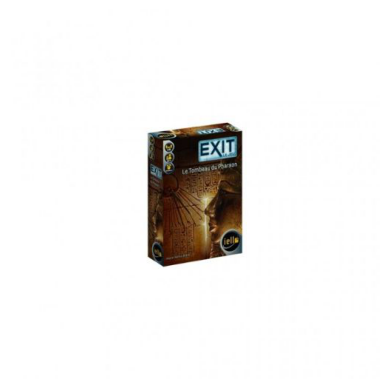

In [119]:
display_image(X_img_sample.iloc[1]["image_path"], print_dim=True)

In [120]:
def to_grayscale(img_path):
    img = Image.open(img_path).convert("L")
    # Passage en float32 pour diviser par 2 la mémoire sans perte notable de précision
    img_gray = np.asarray(img, dtype=np.float32) / 255.0  # Normalisation entre 0 et 1
    return img_gray

Image dimensions: 500x500 pixels


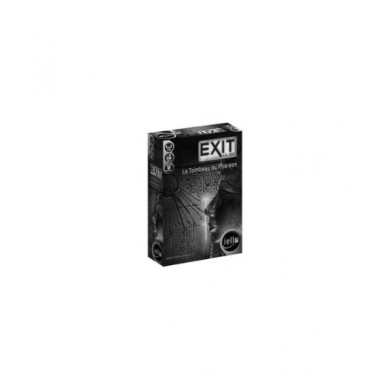

In [121]:
display_image(to_grayscale(X_img_sample.iloc[1]["image_path"]), print_dim=True, cmap="gray")

Réunissons maintenant toutes les images et leurs nuances de gris pour former la heatmap.

In [122]:
# On stock chaque image en niveaux de gris (chacune étant un tableau (W, H)) dans une liste
gray_images = []
for path in X_img_sample["image_path"]:
    img = to_grayscale(path)
    gray_images.append(img)

# On stack les images en un tableau 3D (N, W, H) où N est le nombre d'images
gray_images_array = np.stack(gray_images, axis=0)

# On calcule la moyenne pixel par pixel sur l'axe des images (N)
heatmap_mean = gray_images_array.mean(axis=0)

Affichons maintenant la heatmap !

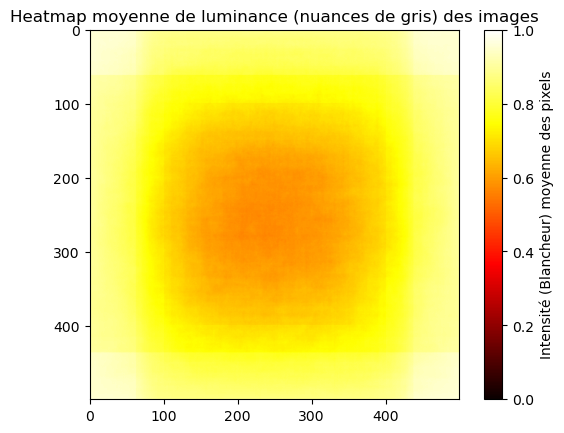

In [123]:
plt.imshow(heatmap_mean, cmap='hot', vmin=0, vmax=1) # Les valeurs vont de 0 (noir) à 1 (blanc)
plt.colorbar(label="Intensité (Blancheur) moyenne des pixels")
plt.title("Heatmap moyenne de luminance (nuances de gris) des images")
plt.show()

Nous voyons déjà bien la répartition des pixels "blancs" rassemblés sur les extérieurs tandis que plus de contenu (ombres/contrastes/couleurs moins blanches) se réunissent plus au centre de l'image.
Les coins prennent bien plus de valeurs blanches.

Nous pouvons également constater que le contraste est assez léger et les moyennes semblent osciller seulement sur la moitié des valeurs possibles. Avant d'analyser un peu plus la heatmap, nous allons donc nous centrer sur les valeurs prises pour observer au mieux les contrastes observables.

Pour cela, prenons quelques données sur les intensités moyennes et centrons la heatmap autour de ces valeurs.

In [124]:
heatmap_mean.mean(), heatmap_mean.min(), heatmap_mean.max()

(0.76731634, 0.56006646, 0.9607998)

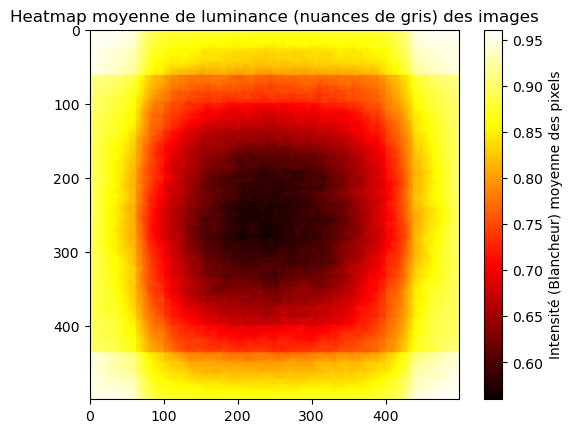

In [125]:
plt.imshow(heatmap_mean, cmap='hot') # Les valeurs vont de 0.56 (noir), 0.96 (blanc)
plt.colorbar(label="Intensité (Blancheur) moyenne des pixels")
plt.title("Heatmap moyenne de luminance (nuances de gris) des images")
plt.show()

En effet, nous observons plus distinctement des propriétés:
- une tâche noire est clairement identifiable au mileu (intensité moyenne plus sombre),
- un vrai carré orange se forme entre (75, 75), (425,75), (425, 425) et (75, 425),
- les côtés jaunes indiquent une grande éclaircie moyenne, des bords non-exploités,
- les coins sont quasiment blancs.

On en conclut que :
- un bon nombre d'images ne sont pas à la bonne dimension mais sont centrées,
- un nombre non-négligeable d'images prennent la totalité de l'espace possible mais sont plus larges que longues (bords jaunes gauche et droite), ou plus longues que larges (bords jaunes haut et bas) car ils laissent notamment les coins blancs.

On s'intéresse donc maintenant à cette différence largeur/hauteur. Pour cela, nous allons étudier la distribution du ratio largeur/hauteur.

#### Distribution du ratio largeur/hauteur

Pour étudier ce ratio, nous avons besoin de la vraie longueur et de la vraie largeur des images, c'est-à-dire sans les bords ou toute mesure vide.

Nous considérons alors le plus petit rectangle dans laquelle nous pouvons placer notre image, c'est-à-dire dans lequel il y a tous les pixels plein (non-blancs) et avec le moins de pixels blancs possible. Cela tombe bien, c'est ce qui s'appelle la Content Box, que nous avons déjà mis en place précédemment !

In [126]:
# Rappel:
print(list(X_img_sample.columns))

# On stoque déjà la largeur et la hauteur du contenu utile dans X_img_sample
# en tant que content_width et content_height

# Calcul du ratio largeur/hauteur qu'on rajoute au sample
X_img_sample["content_ratio"] = np.round(X_img_sample["content_width"] / X_img_sample["content_height"], 4)

['image_path', 'image_shape', 'content_dim', 'content_width', 'content_height', 'x_min', 'y_min', 'x_max', 'y_max', 'content_ratio']


c:\Users\Administrator\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


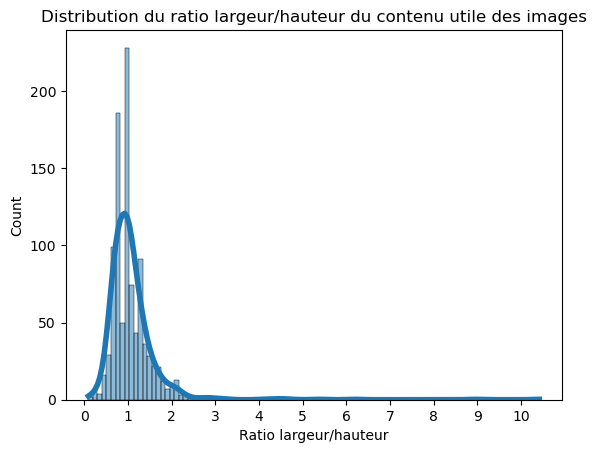

In [127]:
sns.histplot(data=X_img_sample, x="content_ratio", bins=100, kde=True, line_kws={"color" : "red", "linewidth": 4})
plt.title("Distribution du ratio largeur/hauteur du contenu utile des images")
plt.xlabel("Ratio largeur/hauteur")
plt.xticks(np.linspace(0, 10, 11))
plt.show()

Nous observons une distribution plutôt symétrique entre 0 et 2 qui semble centrée en 1. Cependant, un certain nombre de valeurs extrêmes montent jusqu'à 11 ce qui enlève la symétrie. Elles se font toutefois de plus en plus rare à hauteur qu'elles s'éloignent de 1.

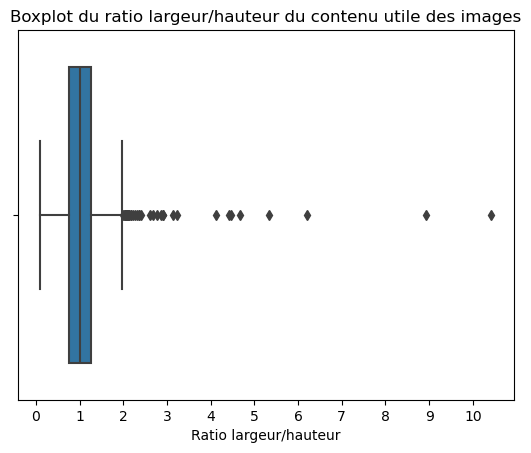

In [128]:
sns.boxplot(data=X_img_sample, x="content_ratio")
plt.title("Boxplot du ratio largeur/hauteur du contenu utile des images")
plt.xlabel("Ratio largeur/hauteur")
plt.xticks(np.linspace(0, 10, 11))
plt.show()

On observe cette fois-ci que la médiane est d'environ un, que les quartiles semblent être symétrique à 1, aux alentours de 0.7 et 1.3, et enfin on remarque que les whiskers (moustaches) forment également presqe une symétrie autour de 1; à 0 et à 2 environ.

Voici de manière chiffrée la moyenne, la variance et l'écart-type de ce ratio.

In [129]:
X_img_sample["content_ratio"].mean(), np.sqrt(X_img_sample["content_ratio"].std()), X_img_sample["content_ratio"].std()


(1.0806678, 0.7924529597118457, 0.6279816933560642)

Nous aurions pu penser à une distribution de type loi normale, mais les longues valeurs extrêmes sur la droite nous en éloignent un peu. Un loi lognormale de petit écart-type est envisageable.

Outre nommer spécifiquement une loi proche de notre distribution, rappelons-nous que les valeurs du ratio largeur/hauteur tendant vers + infini représentent le fait de tendre vers 0 pour le ratio hauteur/largeur, et inversement.

On peut ainsi conclure qu'en moyenne, les images sont aussi longues que larges et qu'il n'y a pas une différence significative entre le nombre d'images essentiellement sur la largeur et le nombre d'images essentiellement sur la hauteur, d'après les boxplots.

#### Conclusion des dimensions

Les images sont centrées, les rebords sont globalement bien plus blancs car les images ne prennent pas la totalité de l'espaces, et les coins sont les moins représentés car ils sont laissés de côté à la fois par les images plus petites, mais aussi par les images dont les dimensions sont asymétriques.

Les images de dimensions asymétriques sont plutôt équitablement réparties entre les images plus longues que larges et les images plus larges que longues.

# Récapitulatif de l'analyse exploratoire des données initiales

|        | Nombre lignes dans la table : ? | 84916                                                                                                             | Pour le dataset utilisable                                                                                                                       |                                                                                                                      |            |                                                                                                                                                                                                                                           |                                                                                                                                                                                                      |                                                                                  |
|--------|---------------------------------|-------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------|------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------|
| N° Col | Nom de la colonne               | Description                                                                                                       | Disponibilité de la variable a priori                                                                                                            | Type informatique                                                                                                    | Taux de NA | Gestion des NA                                                                                                                                                                                                                            | Distribution des valeurs                                                                                                                                                                             | Remarques sur la colonne                                                         |
|        |                                 | Que représente cette variable en quelques mots ?                                                                  | Pouvez vous connaitre ce champ en amont d'une prédiction ? Aurez vous accès à cette variable en environnement de production ?                    | int64, float etc...  Si "object", détaillez.                                                                         | en %       | Quelle mode de (non) - gestion des NA favorisez vous ?                                                                                                                                                                                    | Pour les variables catégorielles comportant moins de 10 catégories, énumérez toutes les catégories.  Pour les variables quantitatives, détaillez la distribution (statistiques descriptives de base) | champs libre à renseigner                                                        |
| 1      | Désignation                     | L’appelation du produit : comme une petite description qui donne l’essentiel sur le produit et donc sa catégorie. | Cette donnée est la base textuelle et est toujours accessible pour la prédiction même en environnement de production.                            | «object » qui est clairement une chaîne de caractères. Certains symboles doivent être changés pour la compréhension. | 0,00 %     | /                                                                                                                                                                                                                                         | C’est un string qui n’est ni quantitatif ni catégoriel. C’est une variable descriptive.                                                                                                              | Les valeurs d’un tel string sont très vastes et une analyse NLP sera nécessaire. |
| 2      | Description                     | Description plus détaillé du produit, de son état, de son utilisation. Regorge d’informations et de mots clés.    | Cette donnée est accessible pour la prédiction même en environnement de production, seulement quand elle n’est pas n/a (nombreuses occurrences). | «object » qui est clairement une chaîne de caractères. Certains symboles doivent être changés pour la compréhension. | 35.09%     | Il s’agit d’une description textuelle : on ne peut la générer pertinemment ni effectuer un remplissage statistique. Soit on l’utilise seulement lorsqu’elle est présente ; soit on fait un remplissage par IA à partir de la désignation. | Identique à la désignation à l’exception des nombreux N/A.                                                                                                                                           | Identique à la désignation.                                                      |
| 3      | productid                       | L’index du produit                                                                                                | N’aura pas de valeur pour être entraîné autre que pour relier le produit (textuel) à son image                                                   | int64                                                                                                                | 0,00 %     | /                                                                                                                                                                                                                                         | /                                                                                                                                                                                                    | /                                                                                |
| 4      | imageid                         | L’index de l’image                                                                                                | N’aura pas de valeur pour être entraîné autre que pour relier le produit (textuel) à son image                                                   | int64                                                                                                                | 0,00 %     | /                                                                                                                                                                                                                                         | /                                                                                                                                                                                                    | /                                                                                |
| 5      | imagepath                       | Le path de l’image pour l’associer au produit                                                                     | Utile en prod pour entraîner sur l’image tout en ayant la bonne évaluation de la classe                                                          | string                                                                                                               | 0.00%      | /                                                                                                                                                                                                                                         | /                                                                                                                                                                                                    | /                                                                                |

# Stratégie envisagée suite à l'exploration des données

Première idée de stratégie:

- Diviser X_train en deux DataFrames : un pour l'entraînement, l'autre pour le test.
- Faire de même pour y_train avec la même répartition.
- Définir si nous décidons de remplir les descriptions nulles par des descriptions générées (identique à la désignation ? mot clé de la désignation ?) ou non.
- Créer un modèle pour classer les produits à partir du texte, incluant du traitement du langage naturel (NLP) sur la désignation et la description de chaque produit.
- Appliquer des algorithmes de Computer Vision pour harmoniser le dataset d'images.
- Transformer les images en vecteurs, associés aux produits, pour créer un DataFrame de pixels.
- Créer un modèle pour classer les produits à partir des images.
- Évaluer les deux modèles.
- Les ajuster ou les améliorer.
- Définir des pondérations pour les deux modèles en fonction de leurs performances.
- Créer une fonction pour obtenir une moyenne pondérée des probabilités pour les meilleures classes. (Comme pour du Bagging)
- Évaluer les résultats en sélectionnant la meilleure classe selon cette moyenne pondérée lors d'une phase de test.
- Tenter d'améliorer les résultats en travaillant sur les pondérations.
- Comparer les performances de ces résultats avec celles du meilleur des deux modèles initiaux.
- Conclure sur la solution (le modèle ou la combinaison) qui serait la plus efficace.